# _import modules:_

In [1]:
# enable In-Line MatPlotLib
%matplotlib inline

In [2]:
# import:
from __future__ import division, print_function
from matplotlib.pyplot import figure, legend, plot, title
from multiprocessing import cpu_count
from numpy import exp, float, int, linspace, log, nan, sqrt
from os import system
from pandas import Categorical, read_csv
from random import seed
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

system('pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies')
from ChicagoBoothML_Helpy.EvaluationMetrics import bin_classif_eval
from ChicagoBoothML_Helpy.Print import printflush

RANDOM_SEED = 99
seed(RANDOM_SEED)

# import Kaggle's _"Give Me Some Credit"_ data set

In [3]:
# read Credit Scoring data into data frame
y_var_name = 'SeriousDlqin2yrs'
X_var_names = [
  'RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents']

cs = read_csv(
    'https://raw.githubusercontent.com/ChicagoBoothML/DATA___Kaggle___GiveMeSomeCredit/master/CreditScoring.csv',
    dtype={
        'SeriousDlqin2yrs': int,
        'RevolvingUtilizationOfUnsecuredLines': float,
        'age': float,
        'NumberOfTime30-59DaysPastDueNotWorse': float,
        'DebtRatio': float,
        'MonthlyIncome': float,
        'NumberOfOpenCreditLinesAndLoans': float,
        'NumberOfTimes90DaysLate': float,
        'NumberRealEstateLoansOrLines': float,
        'NumberOfTime60-89DaysPastDueNotWorse': float,
        'NumberOfDependents': float},
    index_col=0,
    na_values='NA')

cs.loc[:, 'SeriousDlqin2yrs'] = Categorical(cs.SeriousDlqin2yrs)

nb_samples = len(cs)

cs

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0
6,0,0.213179,74,0,0.375607,3500,3,0,1,0,1
7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0
8,0,0.754464,39,0,0.209940,3500,8,0,0,0,0
9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
10,0,0.189169,57,0,0.606291,23684,9,0,4,0,2


Just to sanity-check, the classes of the variables are:

In [4]:
#cs.apply(lambda col: col.dtype)

for col_name in cs:
    printflush('%s: %s' %(col_name, cs[col_name].dtype))

SeriousDlqin2yrs: category
RevolvingUtilizationOfUnsecuredLines: float64
age: float64
NumberOfTime30-59DaysPastDueNotWorse: float64
DebtRatio: float64
MonthlyIncome: float64
NumberOfOpenCreditLinesAndLoans: float64
NumberOfTimes90DaysLate: float64
NumberRealEstateLoansOrLines: float64
NumberOfTime60-89DaysPastDueNotWorse: float64
NumberOfDependents: float64


The incidence of loan delinquency in all samples is:

In [5]:
sum(cs.SeriousDlqin2yrs) / nb_samples

0.066839999999999997

Note that this creates a "**skewed classes**" problem: one of the classes of cases (here the "delinquent" class) is significantly rarer than the other.

_(**note**: in more extreme cases where one class is much, much rarer than the other to the order of 1000 or 10,000 times, our model fitting procedures would need to be tweaked; but this case is not so extreme)_

Let's split the data into a Training set and a Test set:

In [6]:
cs_train, cs_test = train_test_split(
    cs,
    train_size=.2,
    random_state=RANDOM_SEED)

The proportions of missing data points per column in the Training set are as follows:

In [7]:
cs_train.isnull().sum() / len(cs_train)

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198000
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025467
dtype: float64

Let's not throw away valuable data just because of missing values; let's impute missing with the means of the respective columns in the _**Training**_ set:

In [8]:
cs_train_mean_MonthlyIncome = cs_train.MonthlyIncome.mean(skipna=True)
cs_train_mean_NumberOfDependents = cs_train.NumberOfDependents.mean(skipna=True)

cs_train.ix[:, 'MonthlyIncome'] =\
    cs_train.MonthlyIncome.fillna(cs_train_mean_MonthlyIncome, inplace=False)
cs_train.ix[:, 'NumberOfDependents'] =\
    cs_train.NumberOfDependents.fillna(cs_train_mean_NumberOfDependents, inplace=False)

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Let's now split a bit of data from the Training set as a Validation set for the purpose of estimating OOS performance metrics:

In [9]:
cs_train, cs_valid = train_test_split(
    cs_train,
    train_size=2. / 3.,
    random_state=RANDOM_SEED)

Just to sanity-check that the data sets have been split representatively: the delinquency incidences in the Training, Validation and Test sets are:

In [10]:
for data_set in (cs_train, cs_valid, cs_test):
    printflush('%i obs: %f delinquent' %(len(data_set), sum(data_set.SeriousDlqin2yrs) / len(data_set)))

20000 obs: 0.064750 delinquent
10000 obs: 0.067800 delinquent
120000 obs: 0.067108 delinquent


# Classification Models

Let's train 3 types of classification models: a Random Forest, a Boosted Trees model and a Logistic Regression.

In [11]:
B = 600

rf_model = RandomForestClassifier(
    n_estimators=B,
    criterion='entropy',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=200,
    min_samples_leaf=100,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=cpu_count() - 2,   # paralellize over all CPU cores but 2
    class_weight=None,    # our classes are skewed, but but too skewed
    random_state=RANDOM_SEED,
    verbose=0,
    warm_start=False)

rf_model.fit(X=cs_train[X_var_names], y=cs_train.SeriousDlqin2yrs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=6,
            oob_score=True, random_state=99, verbose=0, warm_start=False)

In [12]:
B = 600

boost_model = GradientBoostingClassifier(
    n_estimators=B,
    loss='deviance',   # a.k.a Cross Entropy in Classification
    learning_rate=.01,   # shrinkage parameter
    subsample=1.,
    min_samples_split=200,
    min_samples_leaf=100,
    min_weight_fraction_leaf=0.0,
    max_depth=10,   # maximum tree depth / number of levels of interaction
    init=None,
    random_state=RANDOM_SEED,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    verbose=0,
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    warm_start=False)

boost_model.fit(X=cs_train[X_var_names], y=cs_train.SeriousDlqin2yrs)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=10, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=99, subsample=1.0, verbose=0, warm_start=False)

In [13]:
log_reg_model = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1000.,
    fit_intercept=True,
    intercept_scaling=1.,
    class_weight=None,
    random_state=RANDOM_SEED,
    solver='lbfgs',
    max_iter=100,
    multi_class='multinomial',
    verbose=0)

X_standard_scaler = StandardScaler()
X_standard_scaler.fit(cs_train[X_var_names])
log_reg_model.fit(X=X_standard_scaler.transform(cs_train[X_var_names]), y=cs_train.SeriousDlqin2yrs)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1.0, max_iter=100,
          multi_class='multinomial', penalty='l2', random_state=99,
          solver='lbfgs', tol=0.0001, verbose=0)

We'll now evaluate the OOS performances of these 3 models on the Validation set to select a model we think is best:

In [14]:
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = log(low_prob)
log_high_prob = log(high_prob)
log_prob_thresholds = linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = exp(log_prob_thresholds)

In [15]:
rf_pred_probs = rf_model.predict_proba(X=cs_valid[X_var_names])
rf_oos_performance = bin_classif_eval(
    rf_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
    pos_cat=1, thresholds=prob_thresholds)

In [16]:
boost_pred_probs = boost_model.predict_proba(X=cs_valid[X_var_names])
boost_oos_performance = bin_classif_eval(
    boost_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
    pos_cat=1, thresholds=prob_thresholds)

In [17]:
log_reg_pred_probs = log_reg_model.predict_proba(X=X_standard_scaler.transform(cs_valid[X_var_names]))
log_reg_oos_performance = bin_classif_eval(
    log_reg_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
    pos_cat=1, thresholds=prob_thresholds)

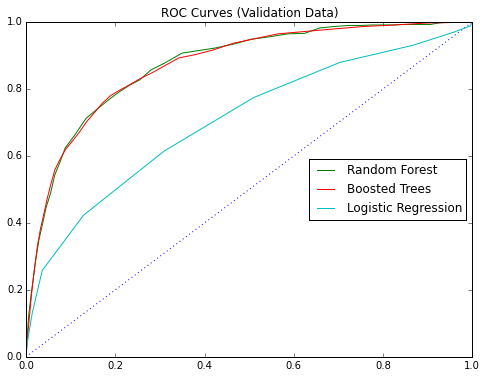

In [18]:
figure(figsize=(8, 6))
plot(
    [0, 1], [0, 1],
    linestyle='dotted')
plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='Random Forest')
plot(
    1 - boost_oos_performance.specificity,
    boost_oos_performance.recall,
    label='Boosted Trees')
plot(
    1 - log_reg_oos_performance.specificity,
    log_reg_oos_performance.recall,
    label='Logistic Regression')
title('ROC Curves (Validation Data)')
legend(loc='right')

We see that Random Forest and Boosted Trees are comparable in OOS performance, and both much better than Logistic Regression. Let's choose the Boosted Trees model for evaluation on the Test set.

We now need to pick a decision threshold for the Boosted Trees model. If we are to be really rigorous, we'll need to pose this trade-off in the context of a financial firm extending loans, e.g. balancing the costs of bad debt and the costs of auditing loans that are healthy. Here, to make life simple, we'll pick a subjective threshold that enables us to anticipate **75%** of the delinquency cases:

In [19]:
recall_threshold = .75
idx = next(i for i in range(100) if boost_oos_performance.recall[i] <= recall_threshold) - 1
selected_prob_threshold = prob_thresholds[idx]
selected_prob_threshold

0.070547966098677431

The OOS performance of the Boosted Trees algorithm at this threshold is as follows:

In [20]:
boost_oos_performance.iloc[idx, :]

threshold      0.070548
accuracy       0.823700
recall         0.758112
specificity    0.828470
precision      0.243256
f1_score       0.368327
deviance       0.358685
Name: 80, dtype: float64

Note that there is trade-off: the precision of the model at this sensitivity threshold is rather low, meaning that there'll be many false positives, i.e. cases with lower financial risk being classified as likely to be delinquent.

# Test Performance of Selected Model

Remember that the Test data may have some missing values. Let's first impute those missing values by the relevant means we've derived from the Training data:

In [21]:
cs_test.ix[:, 'MonthlyIncome'] =\
    cs_test.MonthlyIncome.fillna(cs_train_mean_MonthlyIncome, inplace=False)
cs_test.ix[:, 'NumberOfDependents'] =\
    cs_test.NumberOfDependents.fillna(cs_train_mean_NumberOfDependents, inplace=False)

Let's then evaluate the performance of the selected Boosted Trees model at the decision threshold determined above:

In [22]:
boost_test_pred_probs = boost_model.predict_proba(X=cs_test[X_var_names])
boost_test_oos_performance = bin_classif_eval(
    boost_test_pred_probs[:, 1], cs_test.SeriousDlqin2yrs,
    pos_cat=1, thresholds=selected_prob_threshold)
boost_test_oos_performance

{'accuracy': 0.8227916666666667,
 'deviance': 0.36638410085143336,
 'f1_score': 0.35268332775257982,
 'precision': 0.23360754899588676,
 'recall': 0.71935924500186266,
 'specificity': 0.83023216343448236}

We can see that the Test performance is very similar to what we've estimated from the Validation set. The selected model works as expected.